# Sentiment Analysis usando Deep Learning para español en textos cortos

# 1. Data Cleaning 

We work on a dataset of tweets labelled as positive or negative, more information about the dataset 
can be found on http://www.sepln.org/workshops/tass/. 

The dataset that we used can download here:

- http://www.sepln.org/workshops/tass/2017/#datasets
- http://www.sepln.org/workshops/tass/2018/#datasets

Some description about this datasets:

1. ----
2. ----
3. ----

# 2. Vocabulary

## 2.2 Getting train, validation and test subsets

In [63]:
import lib.xmlreader as xml
import lib.utils as ut
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer

In [64]:
train_docs= xml.readXML("../database/TASS/TASS2018/task1-Training.xml")
test_docs= xml.readXML("../database/TASS/TASS2018/task1-Development.xml")

In [65]:
train_tweets = []
train_labels = []
for doc in train_docs:
    # train_tweets.append(ut.tokenize(doc.content, 0)['clean'])
    train_tweets.append(doc.content)
    train_labels.append(doc.polarity)

test_tweets = []
test_labels = []
for doc in test_docs:
    # test_tweets.append(ut.tokenize(doc.content, 0)['clean'])
    test_tweets.append(doc.content)
    test_labels.append(doc.polarity)

In [66]:
from sklearn.model_selection import train_test_split

SEED = 2000
x_train, x_validation_and_test, y_train, y_validation_and_test = (pd.Series(train_tweets), pd.Series(test_tweets), pd.Series(train_labels), pd.Series(test_labels))
#x_train, x_validation_and_test, y_train, y_validation_and_test = train_test_split(x, y, test_size=.02, random_state=SEED)
x_validation, x_test, y_validation, y_test = train_test_split(x_validation_and_test, y_validation_and_test, test_size=.5, random_state=SEED)

In [67]:
fmt1_ = "Train set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive"
print(fmt1_.format(len(x_train),
      (len(x_train[y_train == 0]) / (len(x_train)*1.))*100,
      (len(x_train[y_train == 1]) / (len(x_train)*1.))*100))
      
fmt2_ = "Validation set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive"
print(fmt2_.format(len(x_validation),
      (len(x_validation[y_validation == 0]) / (len(x_validation)*1.))*100,
      (len(x_validation[y_validation == 1]) / (len(x_validation)*1.))*100))

fmt3_ = "Test set has total {0} entries with {1:.2f}% negative, {2:.2f}% positive"
print(fmt3_.format(len(x_test),
      (len(x_test[y_test == 0]) / (len(x_test)*1.))*100,
      (len(x_test[y_test == 1]) / (len(x_test)*1.))*100))

Train set has total 473 entries with 51.16% negative, 48.84% positive
Validation set has total 100 entries with 54.00% negative, 46.00% positive
Test set has total 101 entries with 51.49% negative, 48.51% positive


## 2.3 Sentence as a list of words

In [68]:
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")
import gensim
from gensim.models.word2vec import Word2Vec
from gensim.models.doc2vec import TaggedDocument
import multiprocessing
from sklearn import utils

Function that replace sentences as a list of words.

In [69]:
def labelize_tweets(tweets,label):
    result = []
    prefix = label
    for i, t in zip(tweets.index, tweets):
        result.append(TaggedDocument(t.split(), [prefix + '_%s' % i]))
    return result

Concat train, validation and test subsets.

In [70]:
all_x = pd.concat([x_train,x_validation,x_test])
all_x_w2v = labelize_tweets(all_x, 'all')

# 3. Preparing Data

In [71]:
counter = CountVectorizer(strip_accents="unicode", tokenizer=ut.tokenizer)

In [72]:
X = counter.fit_transform(train_tweets + test_tweets)
print(X.shape)

(674, 3142)


## 3.1 Word to Number

In [73]:
from gensim.models import KeyedVectors

def gensim_load_vec(path="../database/embeddings/SBW-vectors-300-min5.bin"):
    #use gensim_emb.wv.index2word if used this way to load vectors
    #gensim_emb = gensim.models.word2vec.Word2Vec.load(path)
    gensim_emb =  gensim.models.KeyedVectors.load_word2vec_format(path, binary=True)
    vocab = gensim_emb.index2word
    vec = gensim_emb.syn0
    shape = gensim_emb.syn0.shape
    return gensim_emb, vec, shape, vocab

In [76]:
gensim_emb, vec, shape, vocab = gensim_load_vec()

C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  
C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\ipykernel_launcher.py:9: DeprecationWarning: Call to deprecated `syn0` (Attribute will be removed in 4.0.0, use self.wv.vectors instead).
  if __name__ == '__main__':


We **concatenate vectors of the two models**, build a only vector of 200 dimension, 100 of each model.

In [78]:
embeddings_index = {}
for w in counter.vocabulary_.keys():
    try:
        embeddings_index[w] = gensim_emb[w]
    except KeyError:
        pass
print('Found %s word vectors.' % len(embeddings_index))

Found 2618 word vectors.


Each word is represented as a number.

In [80]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=100000)
tokenizer.fit_on_texts(x_train)
sequences = tokenizer.texts_to_sequences(x_train)

Using TensorFlow backend.


In [81]:
len(tokenizer.word_index)

2572

In [82]:
for x in x_train[:5]:
    print(x)

Sin ser fan de Juan Gabriel, siempre supe que era una fuerza de la naturaleza. Hoy escuché "Querida", y me dio una ternura enorme.
Hoy me sentí como grace de "al fondo hay sitio" cuando la atropellaron, solo que no fue de mentira y casi no la cuento que horrible
hoy me toco visitar a mamá en su descanso eterno le contare todo lo que vivo ella fue es y siempre sera mi MEJOR AMIGA sin igual
Las remuneraciones económicas son lo que todos esperan, pero un "me encanta lo que has hecho", lo vale todo. El cliente es primero.
Lo que mas amo de mi escritorio es que hay una foto de el y mía juntos aparte de mi cuarto mis cuadro también están de el


In [83]:
sequences[:5]

[[62,
  44,
  362,
  2,
  653,
  654,
  40,
  655,
  1,
  80,
  19,
  656,
  2,
  4,
  657,
  37,
  658,
  659,
  3,
  7,
  250,
  19,
  660,
  363],
 [37,
  7,
  661,
  26,
  662,
  2,
  34,
  364,
  63,
  663,
  41,
  4,
  664,
  56,
  1,
  8,
  38,
  2,
  665,
  3,
  251,
  8,
  4,
  252,
  1,
  147],
 [37,
  7,
  365,
  666,
  5,
  203,
  10,
  58,
  667,
  668,
  48,
  669,
  23,
  11,
  1,
  366,
  367,
  38,
  9,
  3,
  40,
  204,
  12,
  29,
  176,
  62,
  100],
 [22,
  670,
  671,
  111,
  11,
  1,
  49,
  672,
  20,
  13,
  7,
  253,
  11,
  1,
  205,
  112,
  11,
  673,
  23,
  6,
  674,
  9,
  254],
 [11,
  1,
  71,
  148,
  2,
  12,
  675,
  9,
  1,
  63,
  19,
  368,
  2,
  6,
  3,
  676,
  369,
  206,
  2,
  12,
  207,
  50,
  677,
  128,
  149,
  2,
  6]]

In [84]:
length = []
for x in x_train:
    length.append(len(x.split()))

In [85]:
max(length)

30

Setting all the data to have the same length of 45

In [86]:
x_train_seq = pad_sequences(sequences, maxlen=45)
print('Shape of data tensor:', x_train_seq.shape)

Shape of data tensor: (473, 45)


By default, if a sentence length is shorter than the maximum length the function replace by zero value at the beginning.

In [87]:
x_train_seq[:5]

array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,  62,  44, 362,   2, 653,
        654,  40, 655,   1,  80,  19, 656,   2,   4, 657,  37, 658, 659,
          3,   7, 250,  19, 660, 363],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,  37,   7, 661,  26, 662,   2,  34,
        364,  63, 663,  41,   4, 664,  56,   1,   8,  38,   2, 665,   3,
        251,   8,   4, 252,   1, 147],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,  37,   7, 365, 666,   5, 203,  10,  58,
        667, 668,  48, 669,  23,  11,   1, 366, 367,  38,   9,   3,  40,
        204,  12,  29, 176,  62, 100],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,  22, 670, 671, 111,
         11,   1,  49, 672,  20,  13,   7, 253,  11,   1, 205, 112,  11,
       

In [88]:
sequences_val = tokenizer.texts_to_sequences(x_validation)
x_val_seq     = pad_sequences(sequences_val, maxlen=45)

When we transform sentences to sequence we set a number to each sentence, these numbers are positions of where word embeddings are stored in the index word of the tokenizer. We build a matrix where the number will be the index of its embedding vector of word.

In [90]:
num_words = 100000
embedding_matrix = np.zeros((num_words, 300))
for word, i in tokenizer.word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [91]:
np.array_equal(embedding_matrix[8] ,embeddings_index.get('you'))

False

# Model: Convolutional Neural Network

In [93]:
seed = 7

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

from keras.layers import Input, Dense, concatenate, Activation
from keras.models import Model
from keras.layers import Conv1D, GlobalMaxPooling1D

tweet_input = Input(shape=(45,), dtype='int32')

tweet_encoder = Embedding(num_words, 300, weights=[embedding_matrix], input_length=45, trainable=True)(tweet_input)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(tweet_encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(tweet_encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(tweet_encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)

merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.2)(merged)
merged = Dense(1)(merged)
output = Activation('sigmoid')(merged)
model = Model(inputs=[tweet_input], outputs=[output])
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 45)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 45, 300)      30000000    input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_1 (Conv1D)               (None, 44, 100)      60100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 43, 100)      90100       embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_3 (

In [95]:
from keras.callbacks import ModelCheckpoint

filepath="model/CNN_best_weights.{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

model.fit(x_train_seq, y_train, batch_size=32, epochs=5,
                     validation_data=(x_val_seq, y_validation), callbacks = [checkpoint])

Train on 473 samples, validate on 100 samples
Epoch 1/5
473/473 [==============================] - 14s 29ms/step - loss: 0.4825 - acc: 0.8372 - val_loss: 0.6488 - val_acc: 0.6500

Epoch 00001: val_acc improved from -inf to 0.65000, saving model to model/CNN_best_weights.01-0.6500.hdf5
Epoch 2/5
473/473 [==============================] - 12s 26ms/step - loss: 0.2604 - acc: 0.9450 - val_loss: 0.6040 - val_acc: 0.6400

Epoch 00002: val_acc did not improve from 0.65000
Epoch 3/5
473/473 [==============================] - 13s 28ms/step - loss: 0.1077 - acc: 0.9852 - val_loss: 0.5571 - val_acc: 0.7600

Epoch 00003: val_acc improved from 0.65000 to 0.76000, saving model to model/CNN_best_weights.03-0.7600.hdf5
Epoch 4/5
473/473 [==============================] - 13s 26ms/step - loss: 0.0303 - acc: 0.9979 - val_loss: 0.5950 - val_acc: 0.7400

Epoch 00004: val_acc did not improve from 0.76000
Epoch 5/5
473/473 [==============================] - 12s 25ms/step - loss: 0.0109 - acc: 1.0000 - val_l

In [98]:
from keras.models import load_model

loaded_CNN_model = load_model('model/CNN_best_weights.03-0.7600.hdf5')
loaded_CNN_model.evaluate(x=x_val_seq, y=y_validation)

100/100 [==============================] - 4s 40ms/step


[0.5571467459201813, 0.76]

In [99]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(max_features=100000,ngram_range=(1, 3))
tvec.fit(x_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.float64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=100000, min_df=1,
        ngram_range=(1, 3), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [100]:
x_train_tfidf = tvec.transform(x_train)
x_test_tfidf = tvec.transform(x_test)

In [103]:
from sklearn.linear_model import LogisticRegression
lr_with_tfidf = LogisticRegression()
lr_with_tfidf.fit(x_train_tfidf,y_train)

C:\Users\dapal\AppData\Local\conda\conda\envs\SI\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [104]:
lr_with_tfidf.score(x_test_tfidf,y_test)

0.6831683168316832

In [105]:
yhat_lr = lr_with_tfidf.predict_proba(x_test_tfidf)

In [106]:
sequences_test = tokenizer.texts_to_sequences(x_test)
x_test_seq = pad_sequences(sequences_test, maxlen=45)

In [107]:
loaded_CNN_model.evaluate(x=x_test_seq, y=y_test)

101/101 [==============================] - 1s 6ms/step


[0.45341178199442306, 0.7821782184119271]

In [108]:
yhat_cnn = loaded_CNN_model.predict(x_test_seq)

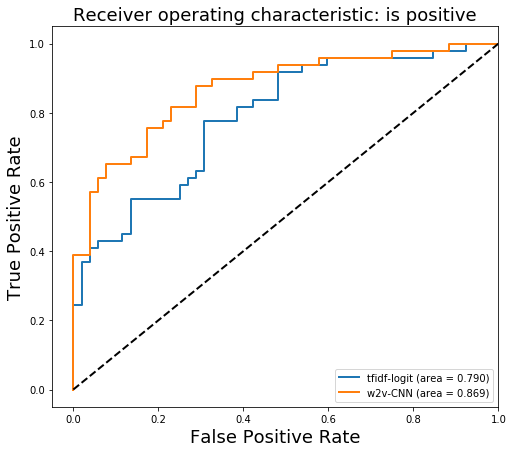

In [110]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(y_test, yhat_lr[:,1])
roc_auc = auc(fpr, tpr)
fpr_cnn, tpr_cnn, threshold = roc_curve(y_test, yhat_cnn)
roc_auc_nn = auc(fpr_cnn, tpr_cnn)
plt.figure(figsize=(8,7))
plt.plot(fpr, tpr, label='tfidf-logit (area = %0.3f)' % roc_auc, linewidth=2)
plt.plot(fpr_cnn, tpr_cnn, label='w2v-CNN (area = %0.3f)' % roc_auc_nn, linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', linewidth=2)
plt.xlim([-0.05, 1.0])
plt.ylim([-0.05, 1.05])
plt.xlabel('False Positive Rate', fontsize=18)
plt.ylabel('True Positive Rate', fontsize=18)
plt.title('Receiver operating characteristic: is positive', fontsize=18)
plt.legend(loc="lower right")
plt.show()